In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.plotting import scatter_matrix
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE, KMeansSMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from data_processing import (identify_merger, clean_hcris_before_2010, clean_hcris_after_2010, imputation_method, resampling)
from grid_search import (grid_search_lr, grid_search_lda, grid_search_knn, grid_search_dt, grid_search_rf, grid_search_xgb)

In [2]:
# ignore warnings
warnings.filterwarnings("ignore")
# Set the display options
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.options.mode.use_inf_as_na = True

# Data preparation

Firstly, I upload the verified data from Lina and identify the potential mergers (details see identify_merger() in data_processing.py).\
Return the data after identification as a dataframe (df1).\
Drop the 'Year of change' after 2012.

In [3]:
verified_data = identify_merger()
verified_data.drop(verified_data[verified_data['Year of change']==2017].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2016].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2015].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2014].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2013].index,inplace=True)

         id  Type of closure  \
0     10009              1.0   
1     10010              5.0   
2     10015              1.0   
3     10025              4.0   
4     10027              1.0   
..      ...              ...   
365  670018              1.0   
366  670021              4.0   
367  670029              5.0   
368  670052              4.0   
369  670066              4.0   

    Type of change (Convert/close/merge/change names)  Year of change  merged  
0                                               Close          2012.0       0  
1                                                Open             NaN       0  
2                                               Close          2011.0       0  
3                                         Open/merger          2013.0       1  
4                                               Close          2013.0       0  
..                                                ...             ...     ...  
365      Close, reopen in 2015 but probably partially  

Secondly, upload the unmatched hospital-level data obtained from Lina as another dataframe (df2).\
Drop the 'Year of change' after 2012.

In [ ]:
hosp_data = pd.read_csv('hosp_closest_info_v5.csv', index_col=0, thousands=',')
print(f"The shape of original HCRIS 2012:{hosp_data.shape}")
# Match the column names with df1
hosp_data.rename(columns={'provider': 'id'}, inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2017].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2016].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2015].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2014].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2013].index,inplace=True)

Merge two dataframes by hospital ids.

In [7]:
verified_hosp_data = pd.merge(verified_data, hosp_data, how='outer')
# Fill the value of column 'merged' in hosp_data not included in verified_data with 0
verified_hosp_data = verified_hosp_data.fillna({'merged':0})

(6408, 45)


# Data cleaning

Drop duplicates and keep the latest date information.

In [8]:
# Return DataFrame with duplicate rows removed except for the id with the recent date.
verified_hosp_data.drop_duplicates(subset=['id'], keep='last', inplace=True)
verified_hosp_data.sort_values(by='id', ascending=True, inplace = True)
verified_hosp_data.reset_index(drop=True, inplace = True)
print(verified_hosp_data.shape)
verified_hosp_data.head(20)

(6313, 45)


,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf
0,10001,NaN,NaN,NaN,0.0,10001.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760.0,NaN,2160.600098,NaN,7790.0,3931.0,17435.0,NaN,NaN,NaN,NaN,NaN,215.0,NaN
1,10005,NaN,NaN,NaN,0.0,10005.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Reopened,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,NaN,BOAZ,AL,35957-,MARSHALL,NaN,NaN,NaN,2891397.0,NaN,NaN,0.1253,NaN,NaN,204.0,74664.0,17787.0,6381.0,36415.0,NaN,1056.020020,NaN,3797.0,1291.0,9168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,10006.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665.0,NaN,968.530029,NaN,5039.0,1765.0,10862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10007,NaN,NaN,NaN,0.0,10007.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,36462-,COVINGTON,NaN,NaN,NaN,185865.0,NaN,NaN,0.0533,NaN,NaN,78.0,28548.0,4122.0,619.0,5867.0,NaN,153.449997,NaN,819.0,133.0,1302.0,NaN,NaN,NaN,NaN,NaN,262.0,NaN
4,10008,NaN,NaN,NaN,0.0,10008.0,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Amended,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,NaN,NaN,NaN,287870.0,NaN,NaN,0.1713,NaN,NaN,29.0,10614.0,1764.0,668.0,3240.0,NaN,106.699997,NaN,374.0,166.0,744.0,NaN,NaN,NaN,104.0,NaN,540.0,NaN
5,10009,1.0,Close,2012.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10010,5.0,Open,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10011,NaN,NaN,NaN,0.0,10011.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Amended,ST. VINCENTS EAST,50 MEDICAL PARK DRIVE EAST,NaN,BIRMINGHAM,AL,35235-,JEFFERSON,1670142.0,NaN,NaN,2023583.0,NaN,NaN,0.0612,787021.0,229995.0,279.0,101835.0,23284.0,10013.0,75795.0,14.660000,1101.239990,NaN,4117.0,1683.0,14380.0,NaN,NaN,NaN,27.0,4.0,421.0,232.0
8,10012,NaN,NaN,NaN,0.0,10012.0,4/1/2012,01-APR-12,3/31/2013,31-MAR-13,Settled,DEKALB REGIONAL MEDICAL CENTER,200 MEDICAL CENTER DRIVE,NaN,FORT PAYNE,AL,35967,DEKALB,NaN,NaN,NaN,928833.0,NaN,NaN,0.1200,NaN,NaN,97.0,35405.0,5771.0,2818.0,13469.0,NaN,371.500000,NaN,1416.0,844.0,3758.0,NaN,NaN,NaN,11.0,NaN,332.0,NaN
9,10015,1.0,Close,2011.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
verified_hcris_data_2012 = pd.read_csv('verified_hcris_data_2012.csv')
verified_hcris_data_2012 = verified_hcris_data_2012.loc[:,['id']]
verified_hcris_data_2012.head(20)

Clean the previous HCRIS data.

In [9]:
# 2010, 2011
hcris_2011 = clean_hcris_after_2010(hcris_2011)
hcris_2010 = clean_hcris_after_2010(hcris_2010)
# 2001-2009
hcris_2009 = clean_hcris_before_2010(hcris_2009)
hcris_2008 = clean_hcris_before_2010(hcris_2008)
hcris_2007 = clean_hcris_before_2010(hcris_2007)
hcris_2006 = clean_hcris_before_2010(hcris_2006)
hcris_2005 = clean_hcris_before_2010(hcris_2005)
hcris_2004 = clean_hcris_before_2010(hcris_2004)
hcris_2003 = clean_hcris_before_2010(hcris_2003)
hcris_2002 = clean_hcris_before_2010(hcris_2002)
hcris_2001 = clean_hcris_before_2010(hcris_2001)

Fill the missing values  with previous HCRIS data

In [10]:
# Copy the data to store both original and modified data
verified_hcris_data_new = verified_hcris_data
# To store the potential closed ids of hospitals (closed before 2012)
closed_ids = []
# Find the index of potential closed id and locate the index to get the corresponding id.
for index in range(len(verified_hcris_data)):
    if verified_hcris_data.iloc[index, :].isnull().sum() >= 40:
        closed_ids.append(verified_hcris_data.iloc[index, 0])
# Search the closed id in previous years' HCRIS data
hcris_prev = [hcris_2011, hcris_2010, hcris_2009, hcris_2008, hcris_2007, hcris_2006,
              hcris_2005, hcris_2004, hcris_2003, hcris_2002, hcris_2001]
for id in closed_ids:
    for data in hcris_prev:
        # Find the location of the id in previous years' data one year after one year.
        closed_ids_prev = data.loc[data['id'].isin([
            id])]
        if not closed_ids_prev.empty:
            closed_index_2012 = verified_hcris_data_new[
                verified_hcris_data.id == id].index
            verified_hcris_data_new.loc[closed_index_2012, ['ime1', 'ime2', 'ime3', 'dsh1', 'dsh2', 'dsh3', 'gme_part_a', 'gme_part_b', 'beds', 'bed_days', 'medicare_days',
                                                            'medicaid_days', 'days', 'employees', 'volunteers', 'medicare_disch', 'medicaid_disch', 'discharges']] = data.loc[closed_ids_prev.index, ['ime1', 'ime2', 'ime3', 'dsh1', 'dsh2', 'dsh3', 'gme_part_a', 'gme_part_b', 'beds', 'bed_days', 'medicare_days',
                                                                                                                                                                                                      'medicaid_days', 'days', 'employees', 'volunteers', 'medicare_disch', 'medicaid_disch', 'discharges']]
            break
verified_hcris_data_new.head(20)

,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf
0,10001,NaN,NaN,NaN,0.0,10001.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760.0,NaN,2160.600098,NaN,7790.0,3931.0,17435.0,NaN,NaN,NaN,NaN,NaN,215.0,NaN
1,10005,NaN,NaN,NaN,0.0,10005.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Reopened,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,NaN,BOAZ,AL,35957-,MARSHALL,NaN,NaN,NaN,2891397.0,NaN,NaN,0.1253,NaN,NaN,204.0,74664.0,17787.0,6381.0,36415.0,NaN,1056.020020,NaN,3797.0,1291.0,9168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,10006.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665.0,NaN,968.530029,NaN,5039.0,1765.0,10862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10007,NaN,NaN,NaN,0.0,10007.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,36462-,COVINGTON,NaN,NaN,NaN,185865.0,NaN,NaN,0.0533,NaN,NaN,78.0,28548.0,4122.0,619.0,5867.0,NaN,153.449997,NaN,819.0,133.0,1302.0,NaN,NaN,NaN,NaN,NaN,262.0,NaN
4,10008,NaN,NaN,NaN,0.0,10008.0,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Amended,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,NaN,NaN,NaN,287870.0,NaN,NaN,0.1713,NaN,NaN,29.0,10614.0,1764.0,668.0,3240.0,NaN,106.699997,NaN,374.0,166.0,744.0,NaN,NaN,NaN,104.0,NaN,540.0,NaN
5,10009,1.0,Close,2012.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175131.0,NaN,NaN,NaN,NaN,NaN,130.0,47450.0,2148.0,293.0,3153.0,NaN,108.370003,NaN,572.0,104.0,967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10010,5.0,Open,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1112826.0,NaN,NaN,NaN,NaN,NaN,90.0,32850.0,10194.0,2185.0,18949.0,NaN,477.600006,NaN,2278.0,482.0,4712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10011,NaN,NaN,NaN,0.0,10011.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Amended,ST. VINCENTS EAST,50 MEDICAL PARK DRIVE EAST,NaN,BIRMINGHAM,AL,35235-,JEFFERSON,1670142.0,NaN,NaN,2023583.0,NaN,NaN,0.0612,787021.0,229995.0,279.0,101835.0,23284.0,10013.0,75795.0,14.660000,1101.239990,NaN,4117.0,1683.0,14380.0,NaN,NaN,NaN,27.0,4.0,421.0,232.0
8,10012,NaN,NaN,NaN,0.0,10012.0,4/1/2012,01-APR-12,3/31/2013,31-MAR-13,Settled,DEKALB REGIONAL MEDICAL CENTER,200 MEDICAL CENTER DRIVE,NaN,FORT PAYNE,AL,35967,DEKALB,NaN,NaN,NaN,928833.0,NaN,NaN,0.1200,NaN,NaN,97.0,35405.0,5771.0,2818.0,13469.0,NaN,371.500000,NaN,1416.0,844.0,3758.0,NaN,NaN,NaN,11.0,NaN,332.0,NaN
9,10015,1.0,Close,2011.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9767.0,NaN,NaN,NaN,NaN,NaN,27.0,3699.0,295.0,NaN,592.0,NaN,75.029999,NaN,92.0,30.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean the data by dropping columns with more than 60% of the values are missing.

In [11]:
# Find the columns with nan greater than 60%
for column in verified_hcris_data_new:
    count_nan = verified_hcris_data_new[column].isna().sum()
    nan_pct = count_nan/len(verified_hcris_data_new[column])*100
    print(f"{column} has {round(nan_pct,2)}% nan")
    if nan_pct > 60:
        verified_hcris_data_new = verified_hcris_data_new.drop(column, axis=1)

id has 0.0% nan
Type of closure has 95.31% nan
Type of change (Convert/close/merge/change names) has 95.31% nan
Year of change has 98.65% nan
merged has 0.0% nan
prvdr_num has 2.87% nan
fyb has 2.87% nan
fybstr has 2.87% nan
fye has 2.87% nan
fyestr has 2.87% nan
status has 2.87% nan
hospital_name has 2.87% nan
street_addr has 2.93% nan
po_box has 85.0% nan
city has 2.87% nan
state has 2.87% nan
zip_code has 2.87% nan
county has 4.72% nan
ime1 has 83.34% nan
ime2 has 99.89% nan
ime3 has 100.0% nan
dsh1 has 56.2% nan
dsh2 has 99.65% nan
dsh3 has 100.0% nan
dshpct has 56.28% nan
gme_part_a has 83.35% nan
gme_part_b has 81.75% nan
beds has 4.36% nan
bed_days has 4.34% nan
medicare_days has 5.08% nan
medicaid_days has 13.39% nan
days has 4.44% nan
intres has 81.02% nan
employees has 5.16% nan
volunteers has 99.05% nan
medicare_disch has 5.12% nan
medicaid_disch has 13.07% nan
discharges has 4.45% nan
medicaid_hmo_discharges has 100.0% nan
medicaid_hmo_ipf_subprovider has 100.0% nan
medicai

Convert non-numerical columns into numeric ones.

In [12]:
verified_hcris_data_new['state'] = verified_hcris_data_new['state'].astype(str)
verified_hcris_data_new['status_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['status'])
verified_hcris_data_new['state_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['state'])
verified_hcris_data_new['city_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['city'])
verified_hcris_data_new['county_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['county'])
# drop the non-numerical columns
verified_hcris_data_new = verified_hcris_data_new.drop(['status', 'state', 'city', 'county', 'prvdr_num', 'fyb', 'fybstr', 'fye', 'fyestr', 'hospital_name', 'street_addr', 'zip_code'], axis=1)

In [13]:
verified_hcris_data_new.reset_index(drop=True, inplace=True)
for index in range(len(verified_hcris_data_new)):
    if verified_hcris_data_new.loc[index, :].isnull().sum() >= 11:
        if verified_hcris_data_new.loc[index,'merged']==0:
            verified_hcris_data_new.drop(index,inplace=True)
verified_hcris_data_new.reset_index(drop=True, inplace = True)

# Check the final data after data cleaning.

(6106, 17)
merged
0.0    5990
1.0     116
dtype: int64
Class 1: 1.8997707173272191%


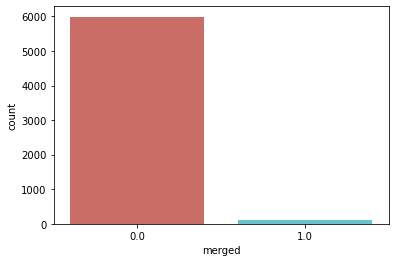

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,status_cat,state_cat,city_cat,county_cat
0,10001,0.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760.0,2160.600098,7790.0,3931.0,17435.0,0,1,756,704
1,10005,0.0,2891397.0,0.1253,204.0,74664.0,17787.0,6381.0,36415.0,1056.020020,3797.0,1291.0,9168.0,2,1,290,939
2,10006,0.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665.0,968.530029,5039.0,1765.0,10862.0,2,1,941,855
3,10007,0.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867.0,153.449997,819.0,133.0,1302.0,3,1,2072,376
4,10008,0.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240.0,106.699997,374.0,166.0,744.0,0,1,1639,387
5,10009,0.0,175131.0,NaN,130.0,47450.0,2148.0,293.0,3153.0,108.370003,572.0,104.0,967.0,5,55,3172,1739
6,10010,0.0,1112826.0,NaN,90.0,32850.0,10194.0,2185.0,18949.0,477.600006,2278.0,482.0,4712.0,5,55,3172,1739
7,10011,0.0,2023583.0,0.0612,279.0,101835.0,23284.0,10013.0,75795.0,1101.239990,4117.0,1683.0,14380.0,0,1,259,755
8,10012,0.0,928833.0,0.1200,97.0,35405.0,5771.0,2818.0,13469.0,371.500000,1416.0,844.0,3758.0,3,1,969,429
9,10015,0.0,9767.0,NaN,27.0,3699.0,295.0,NaN,592.0,75.029999,92.0,30.0,204.0,5,55,3172,1739


In [14]:
print(verified_hcris_data_new.shape)
print(verified_hcris_data_new.groupby('merged').size())
print(f"Class 1: {116/6106*100}%")
sn.countplot(x='merged', data=verified_hcris_data_new, palette='hls')
plt.show()
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
verified_hcris_data_new.head(20)

# ML prediction

Select predictors X and outcome variable y

In [15]:
X, y = verified_hcris_data_new.iloc[:,2:17], verified_hcris_data_new.iloc[:, 1]
# Split the dataset randomly into training dataset (70%) and test dataset (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

Imputate missing values

In [16]:
# Mean imputation
X_train, imp = imputation_method('mean', X_train)
X_test, imp = imputation_method('mean', X_test)
# # Median imputation
# X_train, imp = imputation_method('median', X_train)
# X_test, imp = imputation_method('median', X_test)
# # KNN imputation
# X_train, imp = imputation_method('knn', X_train)
# X_test, imp = imputation_method('knn', X_test)
# # # Multivariate imputation
# X_train, imp = imputation_method('multivariate', X_train)
# X_test, imp = imputation_method('multivariate', X_test)

Resampling methods

In [17]:
BorderlineSMOTE = BorderlineSMOTE(random_state=42,kind="borderline-1")
SMOTE = SMOTE(sampling_strategy=0.3)
SVMSMOTE = SVMSMOTE()
ADASYN = ADASYN()

Tune hyparameters for each model using Gridsearch to find the best hyparameters with highest f1 score.\
For each model, follow the order of original, regular SMOTE, Borderline SMOTE, SVM SMOTE,ADASYN and SMOTE+RUS.

# Logistic Regression (LR)

In [18]:
f1_train_lr_0, f1_lr_0, auprc_lr_0, conf_matrix_lr_0, gridsearch_lr_0 =  grid_search_lr(None, X_test, y_test, X_train, y_train)

Best: 0.707962 using {'C': 1, 'penalty': 'l1'}
The f1 score for the testing data: 0.6122448979591837


In [19]:
f1_train_lr_1, f1_lr_1, auprc_lr_1, conf_matrix_lr_1, gridsearch_lr_1 =  grid_search_lr(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.474614 using {'classifier__C': 1, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.38095238095238093


In [20]:
f1_train_lr_2, f1_lr_2, auprc_lr_2, conf_matrix_lr_2, gridsearch_lr_2 =  grid_search_lr(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.094450 using {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.033707865168539325


In [21]:
f1_train_lr_3, f1_lr_3, auprc_lr_3, conf_matrix_lr_3, gridsearch_lr_3 =  grid_search_lr(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.224861 using {'classifier__C': 500, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.1596244131455399


In [22]:
f1_train_lr_4, f1_lr_4, auprc_lr_4, conf_matrix_lr_4, gridsearch_lr_4 =  grid_search_lr(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.055510 using {'classifier__C': 200, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.030456852791878174


In [23]:
lr = LogisticRegression(solver='liblinear')
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', lr]])
param_grid = {'classifier__C': [
        0.1, 1, 10, 100, 200, 500, 1000], 'classifier__penalty': ['l1', 'l2']}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_lr_5 = gridsearch.best_score_
f1_lr_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_lr_5}')

CV Best: 0.468593 using {'classifier__C': 200, 'classifier__penalty': 'l1'}
Test score: 0.38554216867469876


# LDA

In [24]:
f1_train_lda_0, f1_lda_0, auprc_lda_0, conf_matrix_lda_0, gridsearch_lda_0 =  grid_search_lda(None, X_test, y_test, X_train, y_train)

Best: 0.697558 using {'solver': 'lsqr', 'tol': 1e-05}
The f1 score for the testing data: 0.6122448979591837


In [25]:
f1_train_lda_1, f1_lda_1, auprc_lda_1, conf_matrix_lda_1, gridsearch_lda_1 =  grid_search_lda(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.525793 using {'classifier__solver': 'svd', 'classifier__tol': 0.0003}
The f1 score for the testing data: 0.40540540540540543


In [26]:
f1_train_lda_2, f1_lda_2, auprc_lda_2, conf_matrix_lda_2, gridsearch_lda_2 =  grid_search_lda(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.052146 using {'classifier__solver': 'svd', 'classifier__tol': 1e-05}
The f1 score for the testing data: 0.03162055335968379


In [27]:
f1_train_lda_3, f1_lda_3, auprc_lda_3, conf_matrix_lda_3, gridsearch_lda_3 =  grid_search_lda(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.194744 using {'classifier__solver': 'svd', 'classifier__tol': 0.0003}
The f1 score for the testing data: 0.10210210210210209


In [28]:
f1_train_lda_4, f1_lda_4, auprc_lda_4, conf_matrix_lda_4, gridsearch_lda_4 =  grid_search_lda(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.054931 using {'classifier__solver': 'lsqr', 'classifier__tol': 1e-05}
The f1 score for the testing data: 0.02238805970149254


In [29]:
lda = LinearDiscriminantAnalysis()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', lda]])
param_grid = {
        'classifier__solver': ['svd', 'lsqr', 'eigen'],
        'classifier__tol': [1e-05, 0.0001, 0.0003]
    }
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_lda_5 = gridsearch.best_score_
f1_lda_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_lda_5}')

CV Best: 0.519057 using {'classifier__solver': 'lsqr', 'classifier__tol': 0.0003}
Test score: 0.41666666666666663


# GNB (no para. to tune)

In [30]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_0 = gridsearch.best_score_
f1_gnb_0= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_0}')

CV Best: 0.053000 using {}
Test score: 0.040257648953301126


In [31]:
gnb = GaussianNB()
over = SMOTE
pipeline = Pipeline(steps=[['over', over],
                           ['classifier', gnb]])
param_grid = {}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_1 = gridsearch.best_score_
f1_gnb_1= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_1}')

CV Best: 0.050075 using {}
Test score: 0.03894297635605007


In [32]:
gnb = GaussianNB()
pipeline = Pipeline(steps=[['over', BorderlineSMOTE],
                           ['classifier', gnb]])
param_grid = {}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_2 = gridsearch.best_score_
f1_gnb_2= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_2}')

CV Best: 0.062285 using {}
Test score: 0.022770398481973434


In [33]:
gnb = GaussianNB()
pipeline = Pipeline(steps=[['over', SVMSMOTE],
                           ['classifier', gnb]])
param_grid = {}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_3 = gridsearch.best_score_
f1_gnb_3 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_3}')

CV Best: 0.053910 using {}
Test score: 0.03757225433526011


In [34]:
gnb = GaussianNB()
pipeline = Pipeline(steps=[['over', ADASYN],
                           ['classifier', gnb]])
param_grid = {}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_4 = gridsearch.best_score_
f1_gnb_4 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_4}')

CV Best: 0.053642 using {}
Test score: 0.03862660944206008


In [35]:
gnb = GaussianNB()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', gnb]])
param_grid = {}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_5 = gridsearch.best_score_
f1_gnb_5 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_5}')

CV Best: 0.050357 using {}
Test score: 0.03899721448467967


# KNN

In [36]:
f1_train_knn_0, f1_knn_0, auprc_knn_0, conf_matrix_knn_0, gridsearch_knn_0 =  grid_search_knn(None, X_test, y_test, X_train, y_train)

Best: 0.722775 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'uniform'}
The f1 score for the testing data: 0.0


In [37]:
f1_train_knn_1, f1_knn_1, auprc_knn_1, conf_matrix_knn_1, gridsearch_knn_1 =  grid_search_knn(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.403519 using {'classifier__algorithm': 'kd_tree', 'classifier__leaf_size': 5, 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
The f1 score for the testing data: 0.0


In [ ]:
f1_train_knn_2, f1_knn_2, auprc_knn_2, conf_matrix_knn_2, gridsearch_knn_2 =  grid_search_knn(BorderlineSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_knn_3, f1_knn_3, auprc_knn_3, conf_matrix_knn_3, gridsearch_knn_3 =  grid_search_knn(SVMSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_knn_4, f1_knn_4, auprc_knn_4, conf_matrix_knn_4, gridsearch_knn_4 =  grid_search_knn(ADASYN, X_test, y_test, X_train, y_train)

In [ ]:
knn = KNeighborsClassifier()
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', knn]])
param_grid = {'classifier__weights': ['uniform', 'distance'], 'classifier__n_neighbors': [
        2, 3, 5, 10], 'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'classifier__leaf_size': [2, 5, 10, 20, 30]}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_knn_5 = gridsearch.best_score_
f1_knn_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_knn_5}')

# Decision Tree

In [ ]:
f1_train_dt_0, f1_dt_0, auprc_dt_0, conf_matrix_dt_0, gridsearch_dt_0 =  grid_search_dt(None, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_dt_1, f1_dt_1, auprc_dt_1, conf_matrix_dt_1, gridsearch_dt_1 =  grid_search_dt(SMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_dt_2, f1_dt_2, auprc_dt_2, conf_matrix_dt_2, gridsearch_dt_2 =  grid_search_dt(BorderlineSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_dt_3, f1_dt_3, auprc_dt_3, conf_matrix_dt_3, gridsearch_dt_3 =  grid_search_dt(SVMSMOTE, X_test, y_test, X_train, y_tin)

In [ ]:
f1_train_dt_4, f1_dt_4, auprc_dt_4, conf_matrix_dt_4, gridsearch_dt_4 =  grid_search_dt(ADASYN, X_test, y_test, X_train, y_train)

In [ ]:
dt = DecisionTreeClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', dt]])
param_grid = {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['random', 'best'],
        'classifier__max_depth': [1, 2, 10],
        'classifier__min_samples_leaf': [1, 2, 10]
    }
gridsearch_dt_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_dt_5.fit(X_train, y_train)
f1_train_dt_5 = gridsearch_dt_5.best_score_
f1_dt_5= gridsearch_dt_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_dt_5.best_score_, gridsearch_dt_5.best_params_))
print(f'Test score: {f1_dt_5}')

# Random Forest

In [ ]:
f1_train_rf_0, f1_rf_0, auprc_rf_0, conf_matrix_rf_0, gridsearch_rf_0 =  grid_search_rf(None, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_rf_1, f1_rf_1, auprc_rf_1, conf_matrix_rf_1, gridsearch_rf_1 =  grid_search_rf(SMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_rf_2, f1_rf_2, auprc_rf_2, conf_matrix_rf_2, gridsearch_rf_2 =  grid_search_rf(BorderlineSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_rf_3, f1_rf_3, auprc_rf_3, conf_matrix_rf_3, gridsearch_rf_3 =  grid_search_rf(SVMSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_rf_4, f1_rf_4, auprc_rf_4, conf_matrix_rf_4, gridsearch_rf_4 =  grid_search_rf(ADASYN, X_test, y_test, X_train, y_train)

In [ ]:
rf = RandomForestClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', rf]])
param_grid = {
        'classifier__max_depth': [2, 5, 10, 20],
        'classifier__n_estimators': [10, 100, 1000],
    }
gridsearch_rf_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_rf_5.fit(X_train, y_train)
f1_train_rf_5 = gridsearch_rf_5.best_score_
f1_rf_5 = gridsearch_rf_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_rf_5.best_score_, gridsearch_rf_5.best_params_))
print(f'Test score: {f1_rf_5}')

# XGBoost

In [ ]:
f1_train_xgb_0, f1_xgb_0, auprc_xgb_0, conf_matrix_xgb_0, gridsearch_xgb_0 =  grid_search_xgb(None, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_xgb_1, f1_xgb_1, auprc_xgb_1, conf_matrix_xgb_1, gridsearch_xgb_1 =  grid_search_xgb(SMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_xgb_2, f1_xgb_2, auprc_xgb_2, conf_matrix_xgb_2, gridsearch_xgb_2 =  grid_search_xgb(BorderlineSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_xgb_3, f1_xgb_3, auprc_xgb_3, conf_matrix_xgb_3, gridsearch_xgb_3 =  grid_search_xgb(SVMSMOTE, X_test, y_test, X_train, y_train)

In [ ]:
f1_train_xgb_4, f1_xgb_4, auprc_xgb_4, conf_matrix_xgb_4, gridsearch_xgb_4 =  grid_search_xgb(ADASYN, X_test, y_test, X_train, y_train)

In [ ]:
xgb = XGBClassifier()
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', xgb]])
param_grid = {'classifier__min_child_weight': [1, 5, 10]}
gridsearch_xgb_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_xgb_5.fit(X_train, y_train)
f1_train_xgb_5 = gridsearch_xgb_5.best_score_
f1_xgb_5= gridsearch_xgb_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_xgb_5.best_score_, gridsearch_xgb_5.best_params_))
print(f'Test score: {f1_xgb_5}')

# Evaluation and comparison

The training performance (f1):

In [ ]:
train_models = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Gaussian Naïve Bayes (GNB)', 'Linear Discriminant Analysis (LDA)',
              'Random Forest (RF)', 'Decision Tree (DT)', 'XGBoost (XGB)', 'K-Nearest Neighbor (KNN)'],
    'Original': [f1_train_lr_0, f1_train_gnb_0, f1_train_lda_0,
                 f1_train_rf_0, f1_train_dt_0, f1_train_xgb_0,
                 f1_train_knn_0],
    'SMOTE': [f1_train_lr_1, f1_train_gnb_1, f1_train_lda_1,
              f1_train_rf_1, f1_train_dt_1, f1_train_xgb_1,
              f1_train_knn_1],
    'Borderline SMOTE': [f1_train_lr_2, f1_train_gnb_2, f1_train_lda_2,
                         f1_train_rf_2, f1_train_dt_2, f1_train_xgb_2,
                         f1_train_knn_2],
    'SVM SMOTE': [f1_train_lr_3, f1_train_gnb_3, f1_train_lda_3,
                  f1_train_rf_3, f1_train_dt_3, f1_train_xgb_3,
                  f1_train_knn_3],
    'ADASYN': [f1_train_lr_4, f1_train_gnb_4, f1_train_lda_4,
               f1_train_rf_4, f1_train_dt_4, f1_train_xgb_4,
               f1_knn_4],
    'SMOTE+RUS': [f1_train_lr_5, f1_train_gnb_5, f1_train_lda_5,
                  f1_train_rf_5, f1_train_dt_5, f1_train_xgb_5,
                  f1_train_knn_5]
})
train_models.sort_values(by='Original', ascending=False)

In [ ]:
The test performance (f1):

In [ ]:
test_models = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Gaussian Naïve Bayes (GNB)', 'Linear Discriminant Analysis (LDA)',
              'Random Forest (RF)', 'Decision Tree (DT)', 'XGBoost (XGB)', 'K-Nearest Neighbor (KNN)'],
    'Original': [f1_lr_0, f1_gnb_0, f1_lda_0,
                 f1_rf_0, f1_dt_0, f1_xgb_0,
                 f1_knn_0],
    'SMOTE': [f1_lr_1, f1_gnb_1, f1_lda_1,
              f1_rf_1, f1_dt_1, f1_xgb_1,
              f1_knn_1],
    'Borderline SMOTE': [f1_lr_2, f1_gnb_2, f1_lda_2,
                         f1_rf_2, f1_dt_2, f1_xgb_2,
                         f1_knn_2],
    'SVM SMOTE': [f1_lr_3, f1_gnb_3, f1_lda_3,
                  f1_rf_3, f1_dt_3, f1_xgb_3,
                  f1_knn_3],
    'ADASYN': [f1_lr_4, f1_gnb_4, f1_lda_4,
               f1_rf_4, f1_dt_4, f1_xgb_4,
               f1_knn_4],
    'SMOTE+RUS': [f1_lr_5, f1_gnb_5, f1_lda_5,
                  f1_rf_5, f1_dt_5, f1_xgb_5,
                  f1_knn_5]
})
test_models.sort_values(by='Original', ascending=False)

We can see that  RF, DT and XGBoost performed the best.

# Future prediction

Upload HCRIS data for future prediction

In [ ]:
hcris_2017 = pd.read_csv('ime_gme2552_10_2017.csv')
hcris_2016 = pd.read_csv('ime_gme2552_10_2016.csv')
hcris_2015 = pd.read_csv('ime_gme2552_10_2015.csv')
hcris_2014 = pd.read_csv('ime_gme2552_10_2014.csv')
hcris_2013 = pd.read_csv('ime_gme2552_10_2013.csv')
print(f"2017: {hcris_2017.shape}")
print(f"2016: {hcris_2016.shape}")
print(f"2015: {hcris_2015.shape}")
print(f"2014: {hcris_2014.shape}")
print(f"2013: {hcris_2013.shape}")

In [ ]:
hcris_2017 = clean_hcris_after_2010(hcris_2017)
hcris_2016 = clean_hcris_after_2010(hcris_2016)
hcris_2015 = clean_hcris_after_2010(hcris_2015)
hcris_2014 = clean_hcris_after_2010(hcris_2014)
hcris_2013 = clean_hcris_after_2010(hcris_2013)
print(f"2017: {hcris_2017.shape}")
print(f"2016: {hcris_2016.shape}")
print(f"2015: {hcris_2015.shape}")
print(f"2014: {hcris_2014.shape}")
print(f"2013: {hcris_2013.shape}")

In [ ]:
def make_prediction(model, new_data):
    """Evaluate the predictions of Machine Learning algorithms."""
    X_new = new_data.iloc[:,1:18]
    X_new.fillna(X_new.mean(), inplace=True)
    # make a prediction
    y_pred = model.predict(X_new)
    y_pred_proba = model.predict_proba(X_new)[:, 1]
    return y_pred, y_pred_proba

For each data, use DT, XGB and RF to predict, following the order of original, regular SMOTE, Borderline SMOTE, SVM SMOTE,ADASYN and SMOTE+RUS.

# HCRIS 2017

In [ ]:
y_pred_dt_0, y_pred_proba_dt_0 = make_prediction(gridsearch_dt_0, hcris_2017)
y_pred_xgb_0, y_pred_proba_xgb_0 = make_prediction(gridsearch_xgb_0, hcris_2017)
y_pred_rf_0, y_pred_proba_rf_0 = make_prediction(gridsearch_rf_0, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_0)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_0)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_0)}")

In [ ]:
y_pred_dt_1, y_pred_proba_dt_1 = make_prediction(gridsearch_dt_1, hcris_2017)
y_pred_xgb_1, y_pred_proba_xgb_1 = make_prediction(gridsearch_xgb_1, hcris_2017)
y_pred_rf_1, y_pred_proba_rf_1 = make_prediction(gridsearch_rf_1, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_1)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_1)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_1)}")

In [ ]:
y_pred_dt_2, y_pred_proba_dt_2 = make_prediction(gridsearch_dt_2, hcris_2017)
y_pred_xgb_2, y_pred_proba_xgb_2 = make_prediction(gridsearch_xgb_2, hcris_2017)
y_pred_rf_2, y_pred_proba_rf_2 = make_prediction(gridsearch_rf_2, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_2)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_2)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_2)}")

In [ ]:
y_pred_dt_3, y_pred_proba_dt_3 = make_prediction(gridsearch_dt_3, hcris_2017)
y_pred_xgb_3, y_pred_proba_xgb_3 = make_prediction(gridsearch_xgb_3, hcris_2017)
y_pred_rf_3, y_pred_proba_rf_3 = make_prediction(gridsearch_rf_3, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_3)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_3)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_3)}")

In [ ]:
y_pred_dt_4, y_pred_proba_dt_4 = make_prediction(gridsearch_dt_4, hcris_2017)
y_pred_xgb_4, y_pred_proba_xgb_4 = make_prediction(gridsearch_xgb_4, hcris_2017)
y_pred_rf_4, y_pred_proba_rf_4 = make_prediction(gridsearch_rf_4, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_4)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_4)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_4)}")

In [ ]:
y_pred_dt_5, y_pred_proba_dt_5 = make_prediction(gridsearch_dt_5, hcris_2017)
y_pred_xgb_5, y_pred_proba_xgb_5 = make_prediction(gridsearch_xgb_5, hcris_2017)
y_pred_rf_5, y_pred_proba_rf_5 = make_prediction(gridsearch_rf_5, hcris_2017)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_5)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_5)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_5)}")

# HCRIS 2016

In [ ]:
y_pred_dt_0, y_pred_proba_dt_0 = make_prediction(gridsearch_dt_0, hcris_2016)
y_pred_xgb_0, y_pred_proba_xgb_0 = make_prediction(gridsearch_xgb_0, hcris_2016)
y_pred_rf_0, y_pred_proba_rf_0 = make_prediction(gridsearch_rf_0, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_0)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_0)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_0)}")

In [ ]:
y_pred_dt_1, y_pred_proba_dt_1 = make_prediction(gridsearch_dt_1, hcris_2016)
y_pred_xgb_1, y_pred_proba_xgb_1 = make_prediction(gridsearch_xgb_1, hcris_2016)
y_pred_rf_1, y_pred_proba_rf_1 = make_prediction(gridsearch_rf_1, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_1)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_1)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_1)}")

In [ ]:
y_pred_dt_2, y_pred_proba_dt_2 = make_prediction(gridsearch_dt_2, hcris_2016)
y_pred_xgb_2, y_pred_proba_xgb_2 = make_prediction(gridsearch_xgb_2, hcris_2016)
y_pred_rf_2, y_pred_proba_rf_2 = make_prediction(gridsearch_rf_2, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_2)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_2)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_2)}")

In [ ]:
y_pred_dt_3, y_pred_proba_dt_3 = make_prediction(gridsearch_dt_3, hcris_2016)
y_pred_xgb_3, y_pred_proba_xgb_3 = make_prediction(gridsearch_xgb_3, hcris_2016)
y_pred_rf_3, y_pred_proba_rf_3 = make_prediction(gridsearch_rf_3, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_3)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_3)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_3)}")

In [ ]:
y_pred_dt_4, y_pred_proba_dt_4 = make_prediction(gridsearch_dt_4, hcris_2016)
y_pred_xgb_4, y_pred_proba_xgb_4 = make_prediction(gridsearch_xgb_4, hcris_2016)
y_pred_rf_4, y_pred_proba_rf_4 = make_prediction(gridsearch_rf_4, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_4)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_4)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_4)}")

In [ ]:
y_pred_dt_5, y_pred_proba_dt_5 = make_prediction(gridsearch_dt_5, hcris_2016)
y_pred_xgb_5, y_pred_proba_xgb_5 = make_prediction(gridsearch_xgb_5, hcris_2016)
y_pred_rf_5, y_pred_proba_rf_5 = make_prediction(gridsearch_rf_5, hcris_2016)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_5)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_5)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_5)}")

# HCRIS 2015

In [ ]:
y_pred_dt_0, y_pred_proba_dt_0 = make_prediction(gridsearch_dt_0, hcris_2015)
y_pred_xgb_0, y_pred_proba_xgb_0 = make_prediction(gridsearch_xgb_0, hcris_2015)
y_pred_rf_0, y_pred_proba_rf_0 = make_prediction(gridsearch_rf_0, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_0)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_0)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_0)}")

In [ ]:
y_pred_dt_1, y_pred_proba_dt_1 = make_prediction(gridsearch_dt_1, hcris_2015)
y_pred_xgb_1, y_pred_proba_xgb_1 = make_prediction(gridsearch_xgb_1, hcris_2015)
y_pred_rf_1, y_pred_proba_rf_1 = make_prediction(gridsearch_rf_1, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_1)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_1)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_1)}")

In [ ]:
y_pred_dt_2, y_pred_proba_dt_2 = make_prediction(gridsearch_dt_2, hcris_2015)
y_pred_xgb_2, y_pred_proba_xgb_2 = make_prediction(gridsearch_xgb_2, hcris_2015)
y_pred_rf_2, y_pred_proba_rf_2 = make_prediction(gridsearch_rf_2, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_2)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_2)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_2)}")

In [ ]:
y_pred_dt_3, y_pred_proba_dt_3 = make_prediction(gridsearch_dt_3, hcris_2015)
y_pred_xgb_3, y_pred_proba_xgb_3 = make_prediction(gridsearch_xgb_3, hcris_2015)
y_pred_rf_3, y_pred_proba_rf_3 = make_prediction(gridsearch_rf_3, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_3)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_3)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_3)}")

In [ ]:
y_pred_dt_4, y_pred_proba_dt_4 = make_prediction(gridsearch_dt_4, hcris_2015)
y_pred_xgb_4, y_pred_proba_xgb_4 = make_prediction(gridsearch_xgb_4, hcris_2015)
y_pred_rf_4, y_pred_proba_rf_4 = make_prediction(gridsearch_rf_4, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_4)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_4)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_4)}")

In [ ]:
y_pred_dt_5, y_pred_proba_dt_5 = make_prediction(gridsearch_dt_5, hcris_2015)
y_pred_xgb_5, y_pred_proba_xgb_5 = make_prediction(gridsearch_xgb_5, hcris_2015)
y_pred_rf_5, y_pred_proba_rf_5 = make_prediction(gridsearch_rf_5, hcris_2015)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_5)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_5)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_5)}")

# HCRIS 2014

In [ ]:
y_pred_dt_0, y_pred_proba_dt_0 = make_prediction(gridsearch_dt_0, hcris_2014)
y_pred_xgb_0, y_pred_proba_xgb_0 = make_prediction(gridsearch_xgb_0, hcris_2014)
y_pred_rf_0, y_pred_proba_rf_0 = make_prediction(gridsearch_rf_0, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_0)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_0)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_0)}")

In [ ]:
y_pred_dt_1, y_pred_proba_dt_1 = make_prediction(gridsearch_dt_1, hcris_2014)
y_pred_xgb_1, y_pred_proba_xgb_1 = make_prediction(gridsearch_xgb_1, hcris_2014)
y_pred_rf_1, y_pred_proba_rf_1 = make_prediction(gridsearch_rf_1, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_1)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_1)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_1)}")

In [ ]:
y_pred_dt_2, y_pred_proba_dt_2 = make_prediction(gridsearch_dt_2, hcris_2014)
y_pred_xgb_2, y_pred_proba_xgb_2 = make_prediction(gridsearch_xgb_2, hcris_2014)
y_pred_rf_2, y_pred_proba_rf_2 = make_prediction(gridsearch_rf_2, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_2)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_2)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_2)}")

In [ ]:
y_pred_dt_3, y_pred_proba_dt_3 = make_prediction(gridsearch_dt_3, hcris_2014)
y_pred_xgb_3, y_pred_proba_xgb_3 = make_prediction(gridsearch_xgb_3, hcris_2014)
y_pred_rf_3, y_pred_proba_rf_3 = make_prediction(gridsearch_rf_3, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_3)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_3)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_3)}")

In [ ]:
y_pred_dt_4, y_pred_proba_dt_4 = make_prediction(gridsearch_dt_4, hcris_2014)
y_pred_xgb_4, y_pred_proba_xgb_4 = make_prediction(gridsearch_xgb_4, hcris_2014)
y_pred_rf_4, y_pred_proba_rf_4 = make_prediction(gridsearch_rf_4, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_4)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_4)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_4)}")

In [ ]:
y_pred_dt_5, y_pred_proba_dt_5 = make_prediction(gridsearch_dt_5, hcris_2014)
y_pred_xgb_5, y_pred_proba_xgb_5 = make_prediction(gridsearch_xgb_5, hcris_2014)
y_pred_rf_5, y_pred_proba_rf_5 = make_prediction(gridsearch_rf_5, hcris_2014)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_5)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_5)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_5)}")

# HCRIS 2013

In [ ]:
y_pred_dt_0, y_pred_proba_dt_0 = make_prediction(gridsearch_dt_0, hcris_2013)
y_pred_xgb_0, y_pred_proba_xgb_0 = make_prediction(gridsearch_xgb_0, hcris_2013)
y_pred_rf_0, y_pred_proba_rf_0 = make_prediction(gridsearch_rf_0, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_0)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_0)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_0)}")

In [ ]:
y_pred_dt_1, y_pred_proba_dt_1 = make_prediction(gridsearch_dt_1, hcris_2013)
y_pred_xgb_1, y_pred_proba_xgb_1 = make_prediction(gridsearch_xgb_1, hcris_2013)
y_pred_rf_1, y_pred_proba_rf_1 = make_prediction(gridsearch_rf_1, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_1)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_1)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_1)}")

In [ ]:
y_pred_dt_2, y_pred_proba_dt_2 = make_prediction(gridsearch_dt_2, hcris_2013)
y_pred_xgb_2, y_pred_proba_xgb_2 = make_prediction(gridsearch_xgb_2, hcris_2013)
y_pred_rf_2, y_pred_proba_rf_2 = make_prediction(gridsearch_rf_2, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_2)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_2)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_2)}")

In [ ]:
y_pred_dt_3, y_pred_proba_dt_3 = make_prediction(gridsearch_dt_3, hcris_2013)
y_pred_xgb_3, y_pred_proba_xgb_3 = make_prediction(gridsearch_xgb_3, hcris_2013)
y_pred_rf_3, y_pred_proba_rf_3 = make_prediction(gridsearch_rf_3, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_3)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_3)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_3)}")

In [ ]:
y_pred_dt_4, y_pred_proba_dt_4 = make_prediction(gridsearch_dt_4, hcris_2013)
y_pred_xgb_4, y_pred_proba_xgb_4 = make_prediction(gridsearch_xgb_4, hcris_2013)
y_pred_rf_4, y_pred_proba_rf_4 = make_prediction(gridsearch_rf_4, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_4)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_4)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_4)}")

In [ ]:
y_pred_dt_5, y_pred_proba_dt_5 = make_prediction(gridsearch_dt_5, hcris_2013)
y_pred_xgb_5, y_pred_proba_xgb_5 = make_prediction(gridsearch_xgb_5, hcris_2013)
y_pred_rf_5, y_pred_proba_rf_5 = make_prediction(gridsearch_rf_5, hcris_2013)
print(f"Number of merger using Decision tree is {Counter(y_pred_dt_5)}")
print(f"Number of merger using RF is {Counter(y_pred_rf_5)}")
print(f"Number of merger using XGBoost is {Counter(y_pred_xgb_5)}")